In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import multivariate_normal

# import fitter
from HMC import HMC
from logMultiGaussianLikeli import log_Likelihood_MultidimensionalGaussian
import sys
sys.path.append("..")
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.MultiGaussianLikeli import Likelihood_MultidimensionalGaussian

### **Burn-in**

http://users.stat.umn.edu/~geyer/mcmc/burn.html

*Any point you don't mind having in a sample is a good starting point.*

**One rule I often follow is to start the next run where the last run ended.**

### Data and visualization
With extension to `MCMC_DianZhang/test.ipynb`.

Visualise the distribution $N(\left( \begin{array}{c} 0 \\ 0 \end{array}\right),\left( \begin{array}{cc} 2.5 & 0.5 \\ 0.5 & 2 \end{array}\right))$.  

In [148]:
mean = [0, 0]
cov = [[2.5, 0.5], [0.5, 2.]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

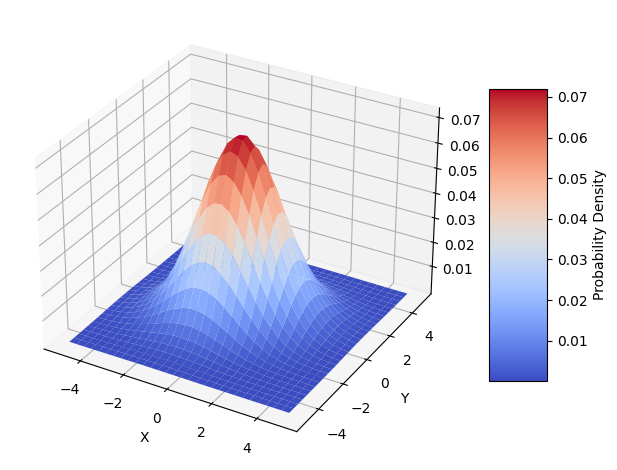

In [142]:
# number of points (30, 30)
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]

# Need an (N, 2) array of (x, y) pairs
DATA = np.dstack((X.flat, Y.flat))
Z = rv.pdf(DATA)
# reshape back to a (30, 30) grid
Z = Z.reshape(X.shape)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Probability Density')
surf = ax.plot_surface(X,Y,Z,cmap='coolwarm')
#wire = ax.plot_wireframe(X,Y,Z,cmap='coolwarm')

fig.colorbar(surf, shrink=0.65,aspect=5,label='Probability Density')
plt.tight_layout()
plt.show()

C:\Users\jq822\AppData\Local\Temp\ipykernel_3516\1480310642.py:5: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, Z, level=15, cmap='Blues')


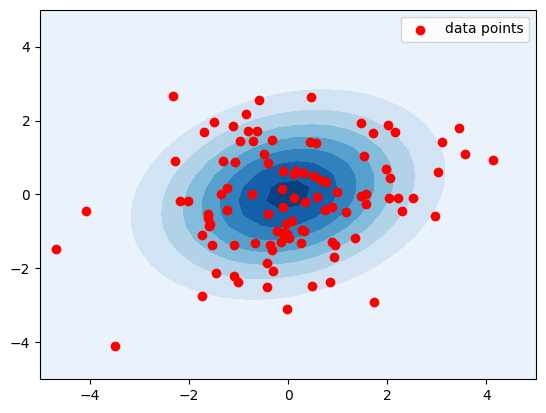

In [143]:
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]
DATA = np.dstack((X, Y))
Z = rv.pdf(DATA)

plt.contourf(X, Y, Z, level=15, cmap='Blues')
plt.scatter(dataset[:,0],dataset[:,1],label='data points',color='red')
plt.legend()
plt.show()

### Likelihood for a 2D Gaus

In [144]:
Likeli = Likelihood_MultidimensionalGaussian(Dim=2, Sigma=cov, Dataset=dataset)

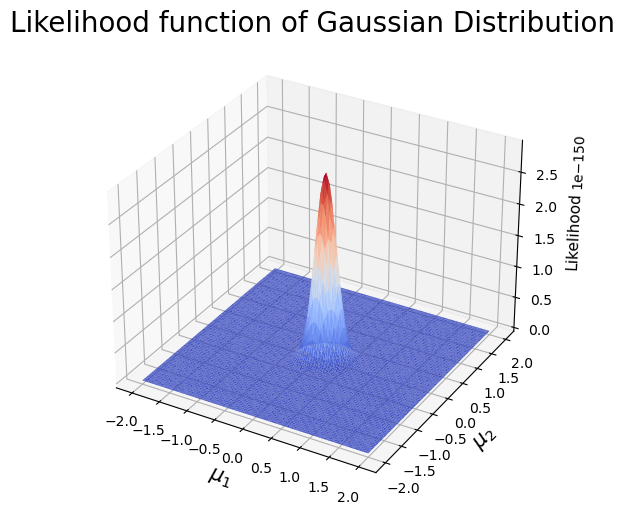

In [12]:
Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid+mean[1])
    x += [g+mean[0]]*r
    z += [Likeli.L([g+mean[0], k+mean[1]]) for k in Grid]
# x, y, z = np.array(x), np.array(y), np.array(z)
# z = z.reshape((100,100))

fig = plt.figure(figsize=(10,6),facecolor="white")

# for i in range(len(z)):
#     z[i] = z[i] / np.std(z)

Gau = fig.add_subplot(projection="3d")
Gau.plot_trisurf(x, y, z, cmap='coolwarm')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("Likelihood", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)

plt.show()

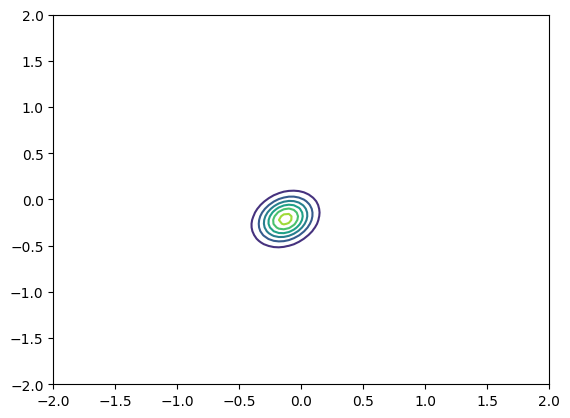

In [13]:
x_, y_ = list(Grid+mean[0]), list(Grid+mean[1])
z_ = np.array(z)
z_ = z_.reshape((len(x_),len(y_)))
plt.contour(x_,y_,z_)

In [14]:
def U(theta: List[float]) -> float: # the potential energy function: U(theta) = -log(probability distribution of theta)
    return (- np.log(Likeli.L(theta)))

def grad_U(theta: List[float]) -> float:
    DRho = Likeli.dLdmu(theta)
    Rho = Likeli.L(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [15]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=[1, 1])

In [17]:
print('The accpetance rate =', len(theta_accept)/(len(theta_reject)+len(theta_accept)))

The accpetance rate = 0.9135


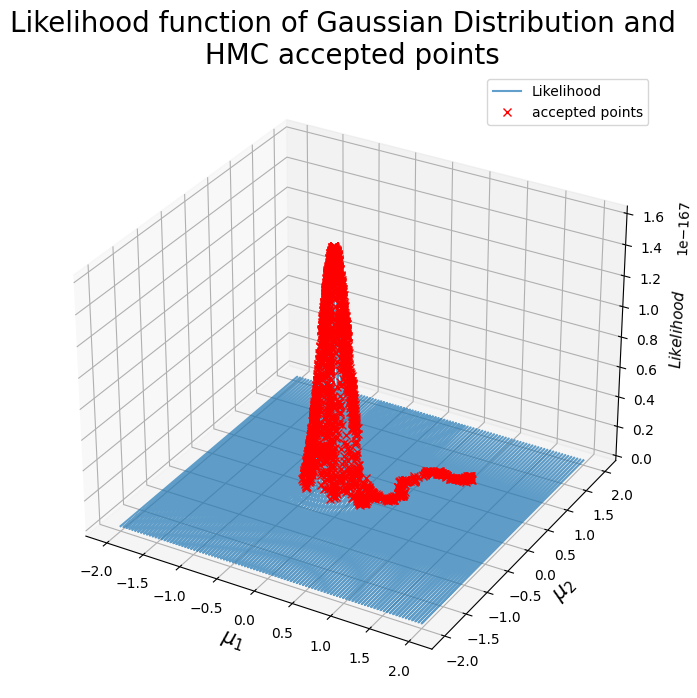

In [29]:
_x = []
_y = []
_z = []
for i in theta_accept:
    _x.append(i[0])
    _y.append(i[1])
    _z.append(Likeli.L([i[0], i[1]]))

Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]

fig = plt.figure(figsize=(8, 8), facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7, label='Likelihood')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$Likelihood$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution and \n HMC accepted points", fontsize=20)

Gau.plot(_x,_y, _z, 'x', color='red', label='accepted points')

plt.legend()
plt.show()

#### log likelihood

$N(\left( \begin{array}{c} 0 \\ 0 \end{array}\right),\left( \begin{array}{cc} 5.0 & 3.0 \\ 3.0 & 5.0 \end{array}\right))$

In [2]:
mean = [0.0, 0.0]
cov = [[5., 3.0], 
       [3.0, 5.]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

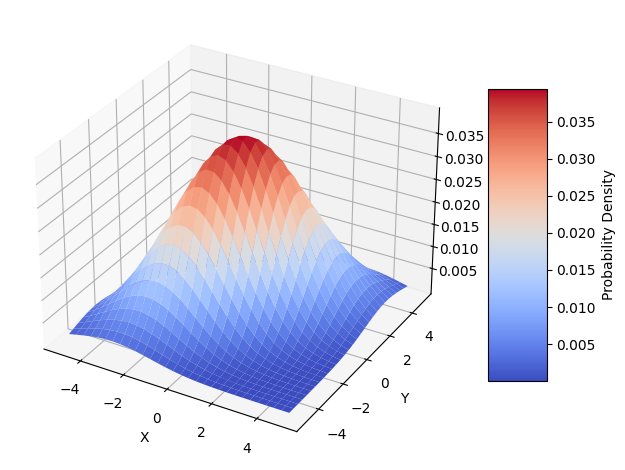

In [3]:
# number of points (30, 30)
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]

# Need an (N, 2) array of (x, y) pairs
DATA = np.dstack((X.flat, Y.flat))
Z = rv.pdf(DATA)
# reshape back to a (30, 30) grid
Z = Z.reshape(X.shape)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Probability Density')
surf = ax.plot_surface(X,Y,Z,cmap='coolwarm')
#wire = ax.plot_wireframe(X,Y,Z,cmap='coolwarm')

fig.colorbar(surf, shrink=0.65,aspect=5,label='Probability Density')
plt.tight_layout()
plt.show()

C:\Users\jq822\AppData\Local\Temp\ipykernel_11236\1491440046.py:5: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, Z, level=15, cmap='Blues')


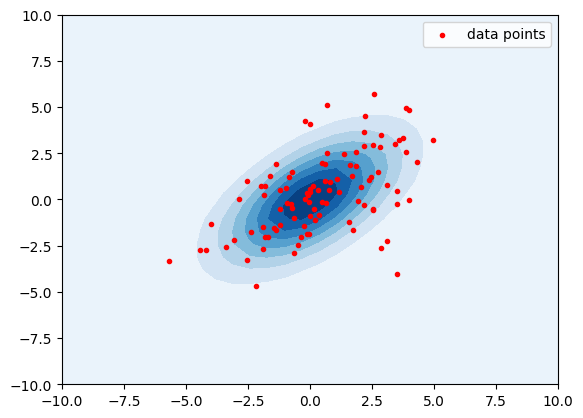

In [4]:
X, Y = np.mgrid[-10.:10.:30j, -10.:10.:30j]
DATA = np.dstack((X, Y))
Z = rv.pdf(DATA)

plt.contourf(X, Y, Z, level=15, cmap='Blues')
plt.scatter(dataset[:,0],dataset[:,1],label='data points',color='red',marker='.')
plt.legend()
plt.show()

In [5]:
logLikeli = log_Likelihood_MultidimensionalGaussian(Dim=2, Sigma=cov, Dataset=dataset)

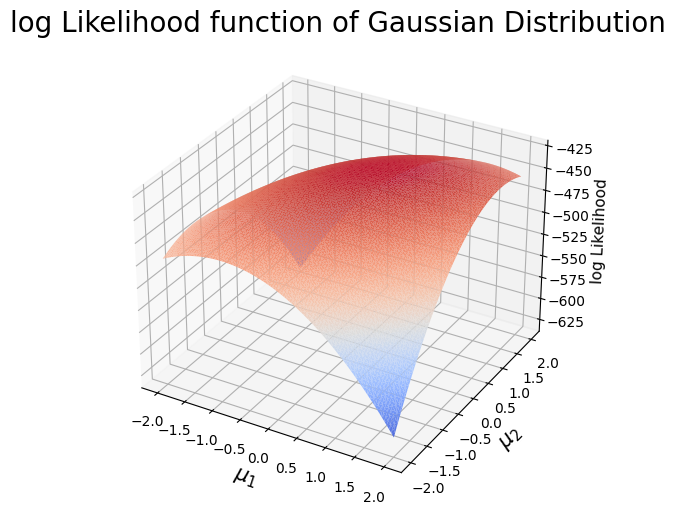

In [6]:
Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid+mean[1])
    x += [g+mean[0]]*r
    z += [logLikeli.logL([g+mean[0], k+mean[1]]) for k in Grid]
# x, y, z = np.array(x), np.array(y), np.array(z)
# z = z.reshape((100,100))

fig = plt.figure(figsize=(10,6),facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot_trisurf(x, y, z, cmap='coolwarm')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("log Likelihood", fontsize=11)
Gau.set_title("log Likelihood function of Gaussian Distribution", fontsize=20)

plt.show()

In [7]:
def U(theta: List[float]) -> float:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - logLikeli.logL(theta)

def grad_U(theta: List[float]) -> float:
    '''
    the derivative of the potential energy function
    dU/dmu
    '''
    DRho = logLikeli.dlogLdmu(theta)
    Rho = logLikeli.logL(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [77]:
theta_accept, theta_reject = HMC(epoch=5000, L=20, epsilon=0.01, U=U, grad_U=grad_U, current_theta=[0, 0])

The accpetance rate = 0.539


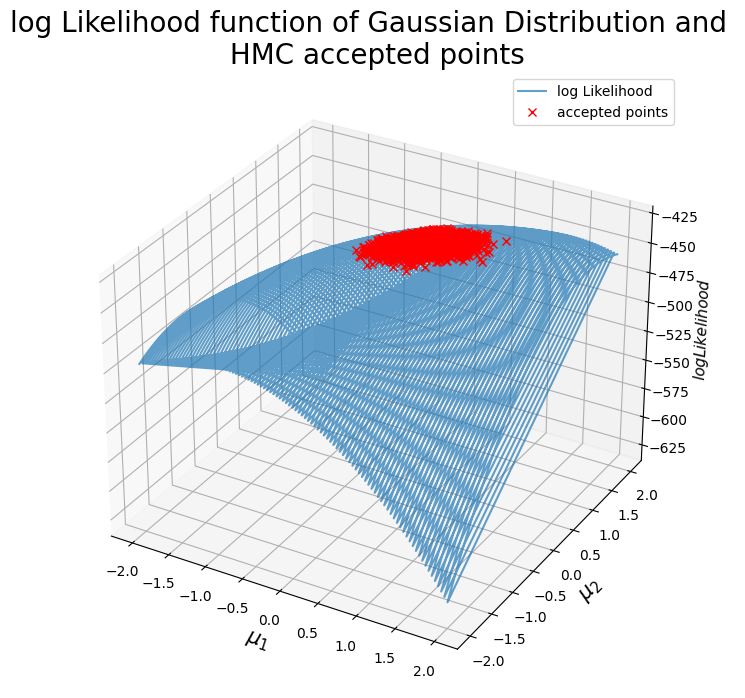

In [78]:
_x = []
_y = []
_z = []
for i in theta_accept:
    _x.append(i[0])
    _y.append(i[1])
    _z.append(logLikeli.logL([i[0], i[1]]))

Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [logLikeli.logL([g, k]) for k in Grid]

fig = plt.figure(figsize=(8, 8), facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7, label='log Likelihood')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$log Likelihood$", fontsize=11)
Gau.set_title("log Likelihood function of Gaussian Distribution and \n HMC accepted points", fontsize=20)

Gau.plot(_x,_y, _z, 'x', color='red', label='accepted points')

print('The accpetance rate =', len(theta_accept)/(len(theta_reject)+len(theta_accept)))
plt.legend()
plt.show()

Text(0, 0.5, 'LLH')

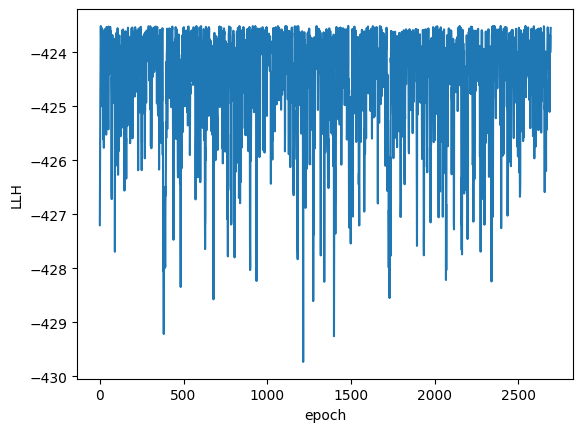

In [104]:
fig = plt.figure()
ax = fig.add_subplot()
no_ = np.arange(0, len(theta_accept),1)
ax.plot(no_, _z)
ax.set_xlabel('epoch')
ax.set_ylabel('LLH')

Text(0, 0.5, '$\\mu_{1}$')

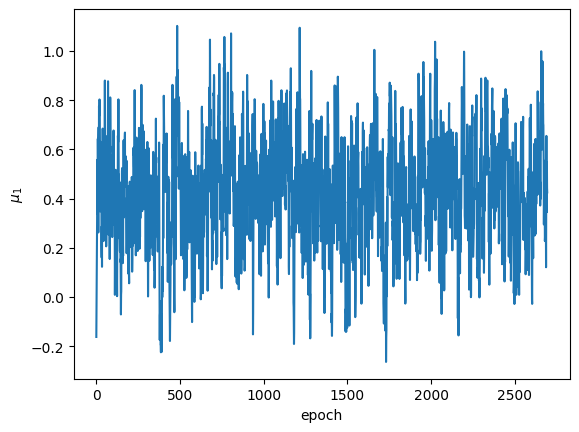

In [110]:
fig = plt.figure()
ax = fig.add_subplot()
no_ = np.arange(0, len(theta_accept),1)
ax.plot(no_, _x)
ax.set_xlabel('epoch')
ax.set_ylabel('$\mu_{1}$')

Text(0, 0.5, '$\\mu_{2}$')

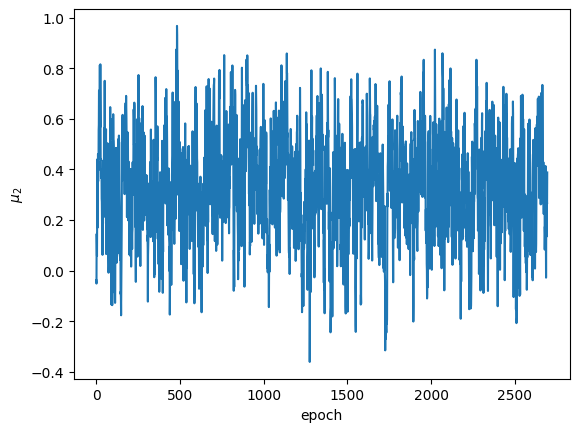

In [106]:
fig = plt.figure()
ax = fig.add_subplot()
no_ = np.arange(0, len(theta_accept),1)
ax.plot(no_, _y)
ax.set_xlabel('epoch')
ax.set_ylabel('$\mu_{2}$')

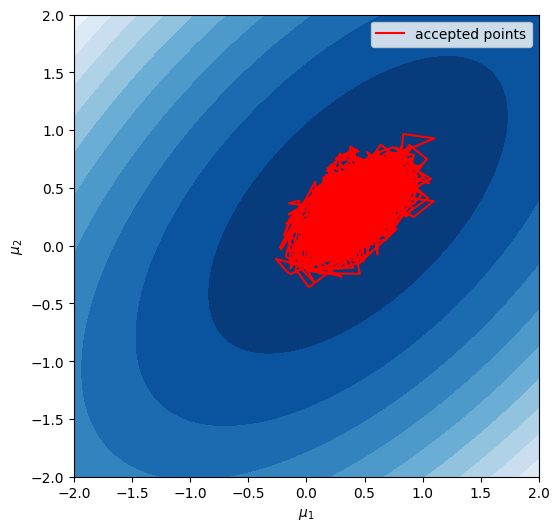

In [79]:
X=np.array(x).reshape((100,100))
Y=np.array(y).reshape((100,100))
Z=np.array(z).reshape((100,100))

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(
    X, Y,
    Z, 
    levels=10,
    cmap='Blues'
)

ax.plot(_x, _y, color='red', label='accepted points')
ax.set_xlabel('$\mu_1$')
ax.set_ylabel('$\mu_2$')

ax.legend()

#### Auto correlation

https://www.statlect.com/fundamentals-of-statistics/autocorrelation

https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

With reference to (http://feldman.faculty.pstat.ucsb.edu/174-03/lectures/l2-3.pdf)

* Autocovariance function:

$$
\begin{aligned}
\gamma_{X} (n, n+k) = Cov (X_{n}, X_{n+k}) = E[(X_{n} - \mu_{X}(n))(X_{n+k} - \mu_{X}(n+k))] = \frac{1}{N-k} \sum^{N-k}_{n=1} (X_{n} - \mu_{X}(n))(X_{n+k} - \mu_{X}(n+k))
\end{aligned}
$$

* Autocorrelation function:

$$
\begin{aligned}
\rho_{X} (n, n+k) \equiv \rho_{X} (k) = Cor (X_{n}, X_{n+k}) = \frac{Cov (X_{n}, X_{n+k})}{\sqrt(Var(X_{n})Var(X_{n+k}))} = \frac{\gamma_{X} (n, n+k)}{\sigma_{X}(n)\sigma_{X}(n+k)}
\end{aligned}
$$

we can write

$$
\begin{aligned}
\rho_{X} (k) = \frac{\gamma_{X}(k)}{\gamma_{X}(0)}
\end{aligned}
$$

where $\gamma_{X}(0)$ is the sample variance.

* Sample Correlation at lag $k$:

$$
\begin{aligned}
\hat{\rho_{k}} = \frac{\frac{1}{N-k} \sum^{N=k}_{n=1} (X_{n} - \hat{\mu})(X_{n+k} - \hat{\mu})}{\frac{1}{N} \sum^{N}_{n=1} (X_{n} - \hat{\mu})^{2}}
\end{aligned}
$$

where $\hat{\mu}$ is the sample mean:

$$
\begin{aligned}
\hat{\mu} = \frac{1}{N} \sum^{N}_{n=1} X_{n}
\end{aligned}
$$

In [50]:
def autocorrelation(chain):
    """
    Computes the autocorrelation of an MCMC chain with multiple dimensions.
    
    Parameters
    ----------
    chain : numpy.ndarray
        A multi-dimension numpy array containing the MCMC samples. Each row should represent a sample and each column should represent a different dimension.
    
    Returns
    -------
    autocorr : numpy.ndarray
        A 1D numpy array containing the autocorrelation values for each dimension at different lags.
    """

    n_samples, n_dims = chain.shape #n_samples = total number of samples in the chain
    mu = np.mean(chain, axis=0) #sample mean
    var = np.var(chain, axis=0, ddof=1) #sample variance computes the sample variance of each dimension of the chain, using the ddof=1 argument to compute the unbiased estimator of the variance
    
    # chain = chain - mu #center the chain around 0
    
    autocov = np.zeros((n_dims, n_samples))
    for k in range(n_samples):
        # `autocov[:, k]` initializes the k-th column of the auto covatiance matrix
        autocov[:, k] = np.sum((chain[:n_samples-k, :] - mu) * (chain[k:, :] - mu), axis=0) / (n_samples - k) #compute autocovariance
    
    # autocorr = autocov / var.reshape(-1, 1) #obtain from autocorrelation function
    autocorr = autocov / autocov[:,[0]] #obtain from autocorrelation function
    
    # # Compute the autocorrelation matrix of the chain
    # autocorr = np.zeros((n_dims, n_samples))
    # for i in range(n_dims):
    #     autocorr[i, :] = autocov[i, :] / var[i]
    
    return autocorr # Add `.mean(axis=1)` if you want to combine the autocorrelation for each dimension

In [12]:
def plot_autocorrelation_dimensions(autocorr):
    n_dims = autocorr.shape[0]
    fig, axs = plt.subplots(n_dims, 1, figsize=(8, 6))

    for i in range(n_dims):
        axs[i].plot(autocorr[i, :], '-')
        axs[i].set_title(f'Dimension {i+1} Autocorrelation')
        axs[i].set_xlabel('Lag')
        axs[i].set_ylabel('Autocorrelation')
        axs[i].set_ylim([-1.1, 1.1])
        axs[i].axhline(y=0, color='gray', linestyle='--')
        axs[i].axhline(y=1, color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()

In [80]:
theta_accept = np.asarray(theta_accept)

In [224]:
mu =  np.mean(theta_accept, axis=0)
sigma = np.std(theta_accept, axis=0, ddof=1)
theta_accept_norm = (theta_accept - mu) / sigma

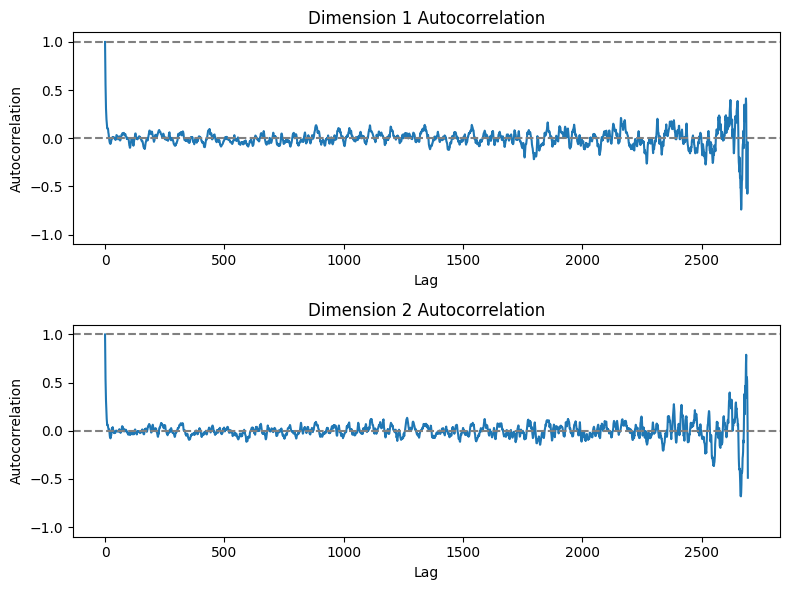

In [81]:
autocorr = autocorrelation(theta_accept)
plot_autocorrelation_dimensions(autocorr)

(-1.0, 1.0)

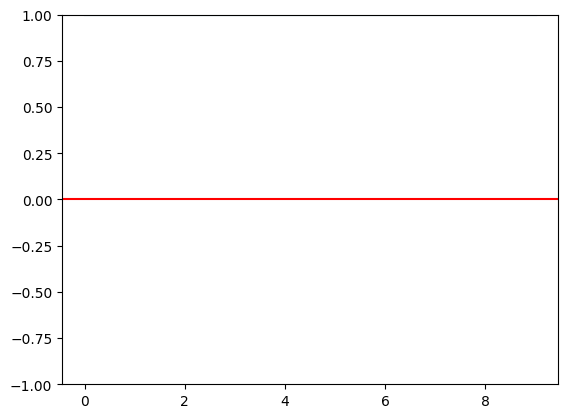

In [92]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(no_, auto_corr)
ax.axhline(y = 0, color = 'r', linestyle = '-')
ax.set_ylim(-1,1)

#### using `numpyro`

In [9]:
from numpyro import distributions

target_dist = distributions.MultivariateNormal(
    np.array([0, 0]), np.array([[2.5, 0.5], 
                           [0.5, 2]]))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

ModuleNotFoundError: No module named 'numpyro'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


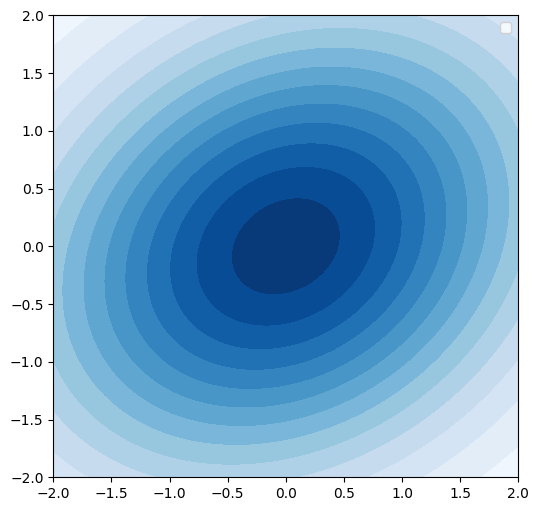

In [ ]:
X, Y = np.meshgrid(np.linspace(-2, 2, 100), 
                   np.linspace(-2, 2, 100), 
                  )

_X = np.stack([X, Y]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(_X.T).reshape((100, 100)))

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(
    X, Y,
    probs, 
    levels=15,
    cmap='Blues'
)

ax.legend()

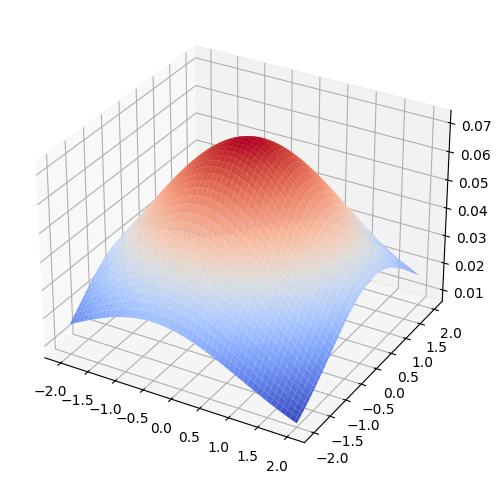

In [ ]:
fig = plt.figure(figsize=(10,6),facecolor="white")

ax = fig.add_subplot(projection="3d")
ax.plot_surface(X,Y,probs,cmap='coolwarm')

### Likelihood for Multi-dimensional Gaus

**Info in the link [How to evaluate the multivariate normal log likelihood](https://blogs.sas.com/content/iml/2020/07/15/multivariate-normal-log-likelihood.html#:~:text=The%20log%2Dlikelihood%20for%20a,also%20called%20a%20log%2DPDF.)**

The log-likelihood for a vector $\mathbf{x}$ is the natural logarithm of the **multivariate normal (MVN)** density function evaluated at $\mathbf{x}$. A probability density function is usually abbreviated as PDF, so the log-density function is also called a log-PDF.

**The multivariate normal PDF**

The multivariate normal distribution in dimension $d$ has two parameters: A d-dimensional mean vector $\mathbf{\mu}$ and a $d \times d$ covariance matrix $\mathbf{\Sigma}$. The MVN PDF evaluated at a d-dimensional vector $\mathbf{x}$ is

$f(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^{d}|\mathbf{\Sigma}|}} exp(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T} \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu}))$

where $\mathbf{\Sigma}$ is the determinant of $\mathbf{\Sigma}$.

**Evaluate the MVN log-likelihood function**

$\log (f(\mathbf{x})) = -\frac{1}{2}[d \log (2 \pi) + log (|\mathbf{\Sigma}|) + MD(\mathbf{x}; \mathbf{\mu}, \mathbf{\Sigma})^{2}]$

where $MD$ is the Mahalanobis distance between the point $\mathbf{x}$ and the mean vector $\mathbf{\mu}$.

$N(\left( \begin{array}{c} 0 \\ 0 \\ 2 \\ 2 \end{array}\right),\left( \begin{array}{cc} 1 & -1 & 2 & 0 \\ -1 & 4 & -1 & 1 \\ 2 & -1 & 6 & -2 \\ 0 & 1 & -2 & 4 \end{array}\right))$

In [2]:
mean = [0, 0, 2, 2]
cov = [[1., -1., 2., 0.], 
        [-1., 4., -1., 1.], 
        [2., -1., 6., -2.], 
        [0., 1., -2., 4.]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

In [3]:
Likeli = Likelihood_MultidimensionalGaussian(Dim=4, Sigma=cov, Dataset=dataset)
logLikeli = log_Likelihood_MultidimensionalGaussian(Dim=4, Sigma=cov, Dataset=dataset)

#### With HMC

from [log likelihood](https://stats.stackexchange.com/questions/27436/how-to-take-derivative-of-multivariate-normal-density)

In [4]:
def U(theta: List[float]) -> float:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - logLikeli.logL(theta)

def grad_U(theta: List[float]) -> float:
    '''
    the derivative of the potential energy function
    dU/dmu
    '''
    DRho = logLikeli.dlogLdmu(theta)
    Rho = logLikeli.logL(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [5]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=np.array([0,0,0,0]))

In [6]:
print('The accpetance rate =', len(theta_accept)/(len(theta_reject)+len(theta_accept)))

The accpetance rate = 0.6145


### Gaussian Mixture

From [link](https://www.statlect.com/fundamentals-of-statistics/Gaussian-mixture-maximum-likelihood)

The **joint probability density funciton** of the n-th observatoin is:

$f(x_{n} | \theta) = \sum^{K}_{k=1} \pi_{k} \frac{1}{\sqrt{(2\pi)^{d} det(\Sigma_{k})|}} exp(-\frac{1}{2}(x_{n}-\mu_{k})^{T} \Sigma_{k}^{-1} (x_{n}-\mu_{k}))$

where $\pi_{k}$ is the mixing coefficient, and $\sum^{K}_{k=1} \pi_{k} = 1$

**Log-likelihood function**:

$
L (X | \theta) = \sum^{N}_{n=1} log(f(x_{n} | \theta)) \\ = \sum^{N}_{n=1} log[\sum^{K}_{k=1} \pi_{k} \mathcal{N}(x_{n}|\mu_{k},\Sigma_{k})] \\ = \sum^{N}_{n=1} log[\sum^{K}_{k=1} \pi_{k} \frac{1}{\sqrt{(2\pi)^{d}|\Sigma_{k}|}} exp(-\frac{1}{2}(x_{n}-\mu_{k})^{T} \Sigma_{k}^{-1} (x_{n}-\mu_{k}))] \\ = \sum^{N}_{n=1} \sum^{K}_{k=1} (log(\pi_{k}) - \frac{1}{2}d \log (2 \pi) - \frac{1}{2} log (|\Sigma_{k}|) - \frac{1}{2} (x_{n}-\mu_{k})^{T} \Sigma_{k}^{-1} (x_{n}-\mu_{k}))
$

**Derivative**: 

[method](https://stats.stackexchange.com/questions/453503/derivation-of-maximum-likelihood-for-a-gaussian-mixture-model): derivative of $\ln(f(x))$ is $\frac{f'}{f(x)}$

$$
\begin{aligned}

\frac{\partial{log(f(x_{n} | \theta))}}{\partial{\mu_{k}}}
= \sum^{N}_{n=1} \frac{1}{\sum^{K}_{k'=1} \pi_{k'} \mathcal{N}(x_{n}|\mu_{k'},\Sigma_{k'})} \times \frac{\partial \sum_{k=1}^{K} \pi_{k} \mathcal{N}(x_{n}|\mu_{k},\Sigma_{k})}{\partial \mu_{k}} \\
= \sum^{N}_{n=1} \frac{\pi_{k} \mathcal{N}(x_{n}|\mu_{k},\Sigma_{k})}{\sum^{K}_{k'=1} \pi_{k'} \mathcal{N}(x_{n}|\mu_{k'},\Sigma_{k'})} \times \Sigma_{k}^{-1}(x_{n}-\mu_{k})

\end{aligned}
$$